In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# Load new data into a pandas DataFrame
path = r"C:\Users\Administrator\UEFA Champions league 2023 stats.xlsx"

In [3]:
matches_new = pd.read_excel(path)

In [4]:
# function for changing columns to lower case
def lower(df):
    df.columns = df.columns.str.lower()
    return df

In [5]:
# Applying function for every dataframe

matches_new = lower(matches_new)

In [6]:
matches_new

,round,match week,datetime,home,xg,score,xg.1,away,venue
0,Group stage,1.0,06-09-22 18:45 (17:45),Dinamo Zagreb,0.6,1–0,0.9,Chelsea FC,Stadion Maksimir
1,Group stage,1.0,06-09-22 18:45 (17:45),Borussia Dortmund,2.3,3–0,0.5,FC Copenhagen,Signal Iduna Park
2,Group stage,1.0,2022-09-06 20:00:00,Celtic FC,1.4,0–3,1.9,Real Madrid,Celtic Park
3,Group stage,1.0,2022-09-06 20:00:00,SL Benfica,1.1,2–0,0.2,Maccabi Haifa,Estádio do Sport Lisboa e Benfica
4,Group stage,1.0,06-09-22 21:00 (20:00),RB Salzburg,1.3,1–1,0.9,AC Milan,Red Bull Arena
...,...,...,...,...,...,...,...,...,...
119,Quarter-finals,NaN,19-04-23 21:00 (20:00),Inter,1.2,3–3,0.7,SL Benfica,Stadio Giuseppe Meazza
120,Semi-finals,NaN,09-05-23 21:00 (20:00),Real Madrid,NaN,NaN,NaN,Manchester City,Estadio Santiago Bernabéu
121,Semi-finals,NaN,10-05-23 21:00 (20:00),AC Milan,NaN,NaN,NaN,Inter,Stadio Giuseppe Meazza
122,Semi-finals,NaN,16-05-23 21:00 (20:00),Inter,NaN,NaN,NaN,AC Milan,Stadio Giuseppe Meazza


In [7]:
matches_new["match week"] = matches_new["match week"].fillna(0).astype(int)


In [8]:
matches_new.dtypes

round          object
match week      int32
datetime       object
home           object
xg            float64
score          object
xg.1          float64
away           object
venue          object
dtype: object

In [9]:
# Fill empty score values with 0
matches_new['score'].fillna('0-0', inplace=True)

matches_new['xg'].fillna('0.0', inplace=True)
matches_new['xg.1'].fillna('0.0', inplace=True)

In [10]:
# replace special hyphen character with regular hyphen symbol
matches_new['score'] = matches_new['score'].str.replace('–', '-')


In [11]:
 #create new columns for home team score and away team score
matches_new[['home_score', 'away_score']] = matches_new['score'].str.split('-', expand=True)

# convert home_score and away_score columns to integers
matches_new['home_score'] = matches_new['home_score'].astype(int)
matches_new['away_score'] = matches_new['away_score'].astype(int)

# create new column to indicate match outcome
matches_new['result'] = np.where(matches_new['home_score'] > matches_new['away_score'], 'W',
                              np.where(matches_new['home_score'] < matches_new['away_score'], 'L', 'D'))

In [12]:
# apply regex replace only to rows that contain '(...)' in the datetime column
matches_new.loc[matches_new['datetime'].str.contains(r'\(.*\)', na=False), 'datetime'] = \
    matches_new.loc[matches_new['datetime'].str.contains(r'\(.*\)', na=False), 'datetime'].str.replace(r'\s*\([^)]*\)\s*', '', regex=True)

In [13]:
matches_new["datetime"] = matches_new["datetime"].str.replace(r'(\d{2})-(\d{2})-(\d{2}\s+\d{2}:\d{2})\s*\([^)]*\)', r'\1-\2-\3', regex=True)



In [14]:
# check the format of the datetime column
format_str = pd.to_datetime(matches_new['datetime'], infer_datetime_format=True).dt.strftime('%Y-%m-%d %H:%M:%S').iloc[0]
print(f'The format of datetime values in the column is: {format_str}')


The format of datetime values in the column is: 2022-06-09 18:45:00


In [15]:
# convert the datetime column to datetime dtype
matches_new['datetime'] = pd.to_datetime(matches_new['datetime'])

In [16]:
matches_new.dtypes

round                 object
match week             int32
datetime      datetime64[ns]
home                  object
xg                    object
score                 object
xg.1                  object
away                  object
venue                 object
home_score             int32
away_score             int32
result                object
dtype: object

In [17]:
matches_new['datetime'] = matches_new['datetime'].fillna(method='ffill') # forward fill missing values with the last valid observation

In [18]:
matches_new["datetime"].isnull().sum()

0

In [19]:
matches_new['opp_code'] = matches_new['away'].astype("category").cat.codes

In [20]:
matches_new["day_code"]=matches_new["datetime"].dt.dayofweek

In [21]:
matches_new['venue_code'] = np.where(matches_new['home']==matches_new['home'], 1, 0)

In [22]:
matches_new["target"] = matches_new["result"].map({"W": 1, "L": 2, "D": 0}).astype("int")

In [23]:
matches_new['season'] = pd.Series([2023] * len(matches_new))

In [24]:
matches_new.rename(columns={'datetime': 'date_time', 'home': 'team', 'away': 'opponent', 'venue': 'stadium', 'home_score': 'home_team_score', 'away_score': 'away_team_score'}, inplace=True)


In [25]:
matches_new

,round,match week,date_time,team,xg,score,xg.1,opponent,stadium,home_team_score,away_team_score,result,opp_code,day_code,venue_code,target,season
0,Group stage,1,2022-06-09 18:45:00,Dinamo Zagreb,0.6,1-0,0.9,Chelsea FC,Stadion Maksimir,1,0,W,7,3,1,1,2023
1,Group stage,1,2022-06-09 18:45:00,Borussia Dortmund,2.3,3-0,0.5,FC Copenhagen,Signal Iduna Park,3,0,W,12,3,1,1,2023
2,Group stage,1,2022-06-09 18:45:00,Celtic FC,1.4,0-3,1.9,Real Madrid,Celtic Park,0,3,L,24,3,1,2,2023
3,Group stage,1,2022-06-09 18:45:00,SL Benfica,1.1,2-0,0.2,Maccabi Haifa,Estádio do Sport Lisboa e Benfica,2,0,W,17,3,1,1,2023
4,Group stage,1,2022-06-09 21:00:00,RB Salzburg,1.3,1-1,0.9,AC Milan,Red Bull Arena,1,1,D,0,3,1,0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,Quarter-finals,0,2023-04-19 21:00:00,Inter,1.2,3-3,0.7,SL Benfica,Stadio Giuseppe Meazza,3,3,D,25,2,1,0,2023
120,Semi-finals,0,2023-09-05 21:00:00,Real Madrid,0.0,0-0,0.0,Manchester City,Estadio Santiago Bernabéu,0,0,D,18,1,1,0,2023
121,Semi-finals,0,2023-10-05 21:00:00,AC Milan,0.0,0-0,0.0,Inter,Stadio Giuseppe Meazza,0,0,D,14,3,1,0,2023
122,Semi-finals,0,2023-05-16 21:00:00,Inter,0.0,0-0,0.0,AC Milan,Stadio Giuseppe Meazza,0,0,D,0,1,1,0,2023


In [26]:
import pandas as pd

matches = pd.read_csv("matches.csv")

In [27]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   match_id           744 non-null    object 
 1   season             744 non-null    int64  
 2   date_time          744 non-null    object 
 3   team               744 non-null    object 
 4   opponent           744 non-null    object 
 5   stadium            744 non-null    object 
 6   home_team_score    744 non-null    int64  
 7   away_team_score    744 non-null    int64  
 8   penalty_shoot_out  744 non-null    int64  
 9   attendance         744 non-null    int64  
 10  result             744 non-null    object 
 11  timestamp          744 non-null    float64
 12  opp_code           744 non-null    int64  
 13  day_code           744 non-null    int64  
 14  venue_code         744 non-null    int64  
 15  target             744 non-null    int64  
 16  total_wins         744 non

In [28]:
# check the format of the datetime column
format_str = pd.to_datetime(matches['date_time'], infer_datetime_format=True).dt.strftime('%Y-%m-%d %H:%M:%S').iloc[0]
print(f'The format of datetime values in the column is: {format_str}')


The format of datetime values in the column is: 2021-09-15 20:00:00


In [29]:
# convert the datetime column to datetime dtype
matches['date_time'] = pd.to_datetime(matches['date_time'])

In [30]:
#matches_new = pd.merge(matches_new, matches[['team', 'total_wins']], on='team', how='left')

In [31]:
matches_new.drop(['round'], axis=1, inplace=True)

In [32]:
matches_new

,match week,date_time,team,xg,score,xg.1,opponent,stadium,home_team_score,away_team_score,result,opp_code,day_code,venue_code,target,season
0,1,2022-06-09 18:45:00,Dinamo Zagreb,0.6,1-0,0.9,Chelsea FC,Stadion Maksimir,1,0,W,7,3,1,1,2023
1,1,2022-06-09 18:45:00,Borussia Dortmund,2.3,3-0,0.5,FC Copenhagen,Signal Iduna Park,3,0,W,12,3,1,1,2023
2,1,2022-06-09 18:45:00,Celtic FC,1.4,0-3,1.9,Real Madrid,Celtic Park,0,3,L,24,3,1,2,2023
3,1,2022-06-09 18:45:00,SL Benfica,1.1,2-0,0.2,Maccabi Haifa,Estádio do Sport Lisboa e Benfica,2,0,W,17,3,1,1,2023
4,1,2022-06-09 21:00:00,RB Salzburg,1.3,1-1,0.9,AC Milan,Red Bull Arena,1,1,D,0,3,1,0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,2023-04-19 21:00:00,Inter,1.2,3-3,0.7,SL Benfica,Stadio Giuseppe Meazza,3,3,D,25,2,1,0,2023
120,0,2023-09-05 21:00:00,Real Madrid,0.0,0-0,0.0,Manchester City,Estadio Santiago Bernabéu,0,0,D,18,1,1,0,2023
121,0,2023-10-05 21:00:00,AC Milan,0.0,0-0,0.0,Inter,Stadio Giuseppe Meazza,0,0,D,14,3,1,0,2023
122,0,2023-05-16 21:00:00,Inter,0.0,0-0,0.0,AC Milan,Stadio Giuseppe Meazza,0,0,D,0,1,1,0,2023


In [33]:
target = matches_new['target']
print(target.value_counts())

1    58
2    37
0    29
Name: target, dtype: int64


In [34]:


# Create a dictionary to keep track of each team's win count
team_wins = {}

# Loop through each match
for i, match in matches.iterrows():

    # Get home and away team names and match result
    home_team = match['team']
    away_team = match['opponent']
    result = match['result']

    # Update home team's win count
    if result == "W":
        if home_team not in team_wins:
            team_wins[home_team] = 0
        team_wins[home_team] += 1

    # Update away team's win count
    elif result == "L":
        if away_team not in team_wins:
            team_wins[away_team] = 0
        team_wins[away_team] += 1

# Create a new DataFrame with total wins for each team
team_wins_df = pd.DataFrame({'team': list(team_wins.keys()), 'total_wins': list(team_wins.values())})

In [35]:
team_wins_df

,team,total_wins
0,Manchester City,40
1,Paris Saint-Germain,31
2,Club Brugge KV,4
3,RB Leipzig,14
4,Liverpool FC,35
...,...,...
56,FK Rostov,1
57,AS Monaco,6
58,Legia Warszawa,1
59,Leicester City,5


In [36]:
matches_new = pd.merge(matches_new, team_wins_df, on='team', how='left')

In [37]:
# Merge the team_wins_df DataFrame with the train and test DataFrames on the team name
#matches_new = pd.merge(matches_new, team_wins_df, on='team', how='left')

In [38]:
matches

,match_id,season,date_time,team,opponent,stadium,home_team_score,away_team_score,penalty_shoot_out,attendance,result,timestamp,opp_code,day_code,venue_code,target,total_wins,total_goals,appearances
0,mt1,2021,2021-09-15 20:00:00,Manchester City,RB Leipzig,Etihad Stadium,6,3,0,38062,W,1.631736e+09,55,2,1,1,40.0,83,32
1,mt2,2021,2021-09-15 20:00:00,Club Brugge KV,Paris Saint-Germain,Jan Breydel Stadion,1,1,0,27546,D,1.631736e+09,53,2,1,0,4.0,9,15
2,mt3,2021,2021-09-28 20:00:00,Paris Saint-Germain,Manchester City,Parc des Princes,2,0,0,37350,W,1.632859e+09,45,1,1,1,31.0,67,27
3,mt4,2021,2021-09-28 20:00:00,RB Leipzig,Club Brugge KV,Red Bull Arena,1,2,0,23500,L,1.632859e+09,19,1,1,2,14.0,26,16
4,mt5,2021,2021-10-19 17:45:00,Club Brugge KV,Manchester City,Jan Breydel Stadion,1,5,0,24915,L,1.634666e+09,45,1,1,2,4.0,9,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,mt740,2016,2017-05-02 19:45:00,Real Madrid,Atlético Madrid,Santiago Bernabéu,3,0,0,77609,W,1.493754e+09,9,1,1,1,41.0,79,33
740,mt741,2016,2017-05-03 19:45:00,AS Monaco,Juventus,Stade Louis II,0,2,0,16762,L,1.493841e+09,36,2,1,2,6.0,15,12
741,mt742,2016,2017-05-09 19:45:00,Juventus,AS Monaco,Allianz Stadium,2,1,0,40244,W,1.494359e+09,5,1,1,1,36.0,47,29
742,mt743,2016,2017-05-10 19:45:00,Atlético Madrid,Real Madrid,Vicente Calderón,2,1,0,53422,W,1.494446e+09,58,2,1,1,24.0,34,26


In [39]:
from sklearn.model_selection import train_test_split

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [41]:
import joblib

# Load the trained Random Forest model from disk
rf = joblib.load("match_prediction_model_rf_test2.joblib")

In [42]:
# Merge the team_wins_df DataFrame with the train and test DataFrames on the team name
#train_matches_new = pd.merge(matches_new, team_wins_df, on='team', how='left')
#test_matches_new = pd.merge(matches_new, team_wins_df, on='team', how='left')

In [43]:
# Group data by team name and calculate most goals scored by that team
matches_new['total_goals'] = matches['home_team_score'].groupby(matches['team']).transform('sum')

In [44]:
# Count number of appearances for each team in the dataset
appearances = matches['team'].value_counts()

In [45]:
# Add new feature 'appearances' to the matches dataframe
matches_new['appearances'] = matches['team'].map(appearances)

In [46]:
# Define the predictors
predictors = ["venue_code", "opp_code", "day_code", "total_wins", "total_goals", "appearances"]

In [47]:
train=matches[matches["date_time"]< '2022-06-01']

In [48]:
test = matches_new[matches_new["date_time"] > '2022-06-01']

In [49]:
matches_new['total_wins'] = matches_new['total_wins'].fillna(method='ffill')

In [50]:
train[predictors].head()

,venue_code,opp_code,day_code,total_wins,total_goals,appearances
0,1,55,2,40.0,83,32
1,1,53,2,4.0,9,15
2,1,45,1,31.0,67,27
3,1,19,1,14.0,26,16
4,1,45,1,4.0,9,15


In [51]:
matches_new

,match week,date_time,team,xg,score,xg.1,opponent,stadium,home_team_score,away_team_score,result,opp_code,day_code,venue_code,target,season,total_wins,total_goals,appearances
0,1,2022-06-09 18:45:00,Dinamo Zagreb,0.6,1-0,0.9,Chelsea FC,Stadion Maksimir,1,0,W,7,3,1,1,2023,1.0,83,32
1,1,2022-06-09 18:45:00,Borussia Dortmund,2.3,3-0,0.5,FC Copenhagen,Signal Iduna Park,3,0,W,12,3,1,1,2023,21.0,9,15
2,1,2022-06-09 18:45:00,Celtic FC,1.4,0-3,1.9,Real Madrid,Celtic Park,0,3,L,24,3,1,2,2023,1.0,67,27
3,1,2022-06-09 18:45:00,SL Benfica,1.1,2-0,0.2,Maccabi Haifa,Estádio do Sport Lisboa e Benfica,2,0,W,17,3,1,1,2023,10.0,26,16
4,1,2022-06-09 21:00:00,RB Salzburg,1.3,1-1,0.9,AC Milan,Red Bull Arena,1,1,D,0,3,1,0,2023,6.0,9,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,2023-04-19 21:00:00,Inter,1.2,3-3,0.7,SL Benfica,Stadio Giuseppe Meazza,3,3,D,25,2,1,0,2023,9.0,60,28
120,0,2023-09-05 21:00:00,Real Madrid,0.0,0-0,0.0,Manchester City,Estadio Santiago Bernabéu,0,0,D,18,1,1,0,2023,41.0,83,32
121,0,2023-10-05 21:00:00,AC Milan,0.0,0-0,0.0,Inter,Stadio Giuseppe Meazza,0,0,D,14,3,1,0,2023,1.0,60,28
122,0,2023-05-16 21:00:00,Inter,0.0,0-0,0.0,AC Milan,Stadio Giuseppe Meazza,0,0,D,0,1,1,0,2023,9.0,8,6


In [52]:
from sklearn.impute import SimpleImputer

# create an imputer object with a strategy to replace missing values with mean of the column
imputer = SimpleImputer(strategy='mean')

# fit the imputer on training data to learn the mean of each column
imputer.fit(train[predictors])

# transform the training and test data to replace missing values with the learned means
train.loc[:, predictors] = imputer.transform(train[predictors])
test.loc[:, predictors] = imputer.transform(test[predictors])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16596\1267171643.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:, predictors] = imputer.transform(train[predictors])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16596\1267171643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, predictors] = imputer.transform(test[predictors])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16596\1267171643.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to 

In [53]:
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=8, n_estimators=50, random_state=1)

In [54]:
predictors

['venue_code',
 'opp_code',
 'day_code',
 'total_wins',
 'total_goals',
 'appearances']

In [55]:
matches_new.dtypes

match week                  int32
date_time          datetime64[ns]
team                       object
xg                         object
score                      object
xg.1                       object
opponent                   object
stadium                    object
home_team_score             int32
away_team_score             int32
result                     object
opp_code                     int8
day_code                    int64
venue_code                  int32
target                      int32
season                      int64
total_wins                float64
total_goals                 int64
appearances                 int64
dtype: object

In [56]:
preds=rf.predict(test[predictors])

In [57]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test["target"], preds)
print("Accuracy:", accuracy)


Accuracy: 0.3870967741935484


In [58]:
result_df = pd.concat([test['target'], pd.Series(preds, name='predicted', index=test.index)], axis=1)
print(result_df)

     target  predicted
0         1          1
1         1          2
2         2          1
3         1          1
4         0          0
..      ...        ...
119       0          1
120       0          1
121       0          1
122       0          0
123       0          1

[93 rows x 2 columns]


In [59]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(test["target"], preds)
print(cm)


[[ 3 14  8]
 [ 0 20 20]
 [ 2 13 13]]


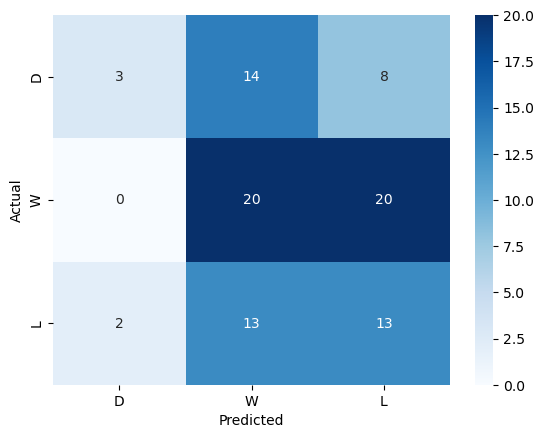

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["D", "W", "L"], yticklabels=["D", "W", "L"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
combined=pd.DataFrame(dict(actual=test["target"], prediction=preds))

In [62]:
pd.crosstab(index=combined["actual"], columns= combined["prediction"])

prediction,0,1,2
actual,,,
0,3,14,8
1,0,20,20
2,2,13,13


In [63]:
from sklearn.metrics import precision_score

precision = precision_score(test["target"], preds, average='weighted', zero_division=1)
print("Precision Score: {:.2f}".format(precision))

Precision Score: 0.44


In [64]:
from sklearn.metrics import f1_score

f1 = f1_score(test["target"], preds, average='weighted')
print("F1 Score: {:.2f}".format(f1))


F1 Score: 0.36


In [65]:
matches_new.to_csv('matches_new.csv', index=False)

In [66]:
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.model_selection import GridSearchCV

# define the parameter grid to search over
param_grid = {'max_depth': [3, 5, 7, 9], 'learning_rate': [0.001, 0.01, 0.1, 1]}

# create a gradient boosting classifier
gbc = GradientBoostingClassifier()

# create the grid search object
gs = GridSearchCV(gbc, param_grid, cv=5)

In [68]:
# Fit the randomized search object to the data
gs.fit(train[predictors], train["target"])

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'max_depth': [3, 5, 7, 9]})

In [69]:
# extract the results of the grid search
results = gs.cv_results_


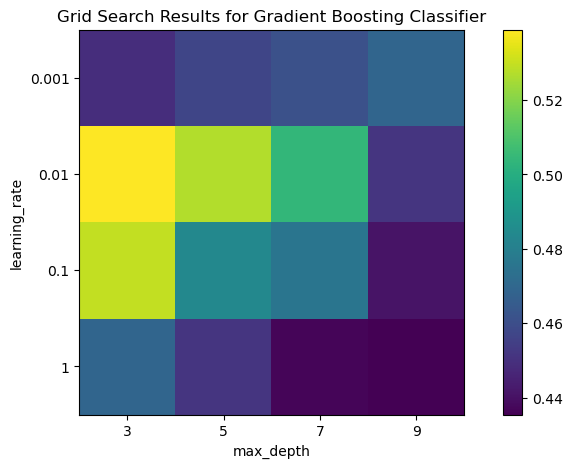

In [70]:
# plot the results of the grid search
plt.figure(figsize=(10, 5))
plt.title("Grid Search Results for Gradient Boosting Classifier")
plt.xlabel("max_depth")
plt.ylabel("learning_rate")
plt.imshow(results['mean_test_score'].reshape(4, 4), cmap='viridis', interpolation='nearest')
plt.xticks(range(len(param_grid['max_depth'])), param_grid['max_depth'])
plt.yticks(range(len(param_grid['learning_rate'])), param_grid['learning_rate'])
plt.colorbar()
plt.show()